# ISFC Greedy Boundary Search Analysis

This notebook uses greedy state boundary search (GSBS) to segment dynamic ISFC time series (i.e. intersubject cofluctuation across PCA-reduced LSTMs) into "event"-like network configurations. The goal is to identify network-level events shared between agents on the same team, and ultimately relate these network events to cooperative behavior. To collate network events across games, we cluster the events using a Gaussian mixture model (GMM).

*Author: Andrew Goldberg*


Table of Contents:
* [Vectorizing Intersubject Cofluctuation Patterns and Running GSBS](#vectorizing-isfc)
* [Visualizing ISCFS and GSBS Results](#Visualizing-ISCFS-and-GSBS-Results)
    * [Plot of optimal number of events for GSBS](#Plot-of-optimal-number-of-events-for-GSBS)
    * [Correlation matrix for first 1000 timepoints for test repeat and pair](#Correlation-matrix-for-first-1000-timepoints-for-test-repeat-and-pair)
    * [Correlation matrix for GSBS game-state patterns](#Correlation-matrix-for-GSBS-game--state-patterns)
* [GMM Clustering Analyses](#GMM-Clustering-Analyses)
    * [First Attempt: 30 components, no PCA](#First-Attempt:-30-components,-no-PCA)
    * [Attempt Two: PCA GSBS results first w/ 1000 components, then 30 component GMM](#Attempt-Two:-PCA-GSBS-results-first-w/-1000-components,-then-30-component-GMM)
    * [Based on Results from previous PCA + GMM combo, Run GMM at k = 6 Components](#Based-on-Results-from-previous-PCA-+-GMM-combo,-Run-GMM-at-k-=-6-Components)
* [Miscellaneous Visualizations of GSBS Results and ISFC Results](#Miscellaneous-Visualizations-of-GSBS-Results-and-ISFC-Results)
    * [GMM Cluster Means (for components [0,5]) projected into the 100 by 100 Cofluctuation space](#GMM-Cluster-Means-(for-components-[0,5])-projected-into-the-100-by-100-Cofluctuation-space)
    * [GMM clustering labels for the 2898 GSBS state patterns](#GMM-clustering-labels-for-the-2898-GSBS-state-patterns)
    * [PCA 684 components (90% VAF) and GMM k = 5 Components](#PCA-684-components-(90%-VAF)-and-GMM-k-=-5-Components)
    * [Visualize GMM label results projected back into 4500 timepoint space](#Visualize-GMM-label-results-projected-back-into-4500-timepoint-space)
    
    

In [29]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import scipy as sp
import scipy.special
from sklearn import manifold
import pickle

import sys
sys.path.insert(0, '/jukebox/hasson/snastase/social-ctf')
from ctf_dataset import load
from ctf_dataset import info
from ctf_dataset.info import constants
from ctf_dataset.info import events
from ctf_dataset.load import virtual
from ctf_dataset.load import utils as load_utils
from scipy.spatial.distance import squareform
from statesegmentation import GSBS

<a id='vectorizing-isfc' target=internal></a>
## Vectorizing Intersubject Cofluctuation Patterns and Running GSBS

We first load in the cofluctuation matrices with shape `(8, 6, 4501, 100, 100)` representing (repeats, pairs of agents, timepoints, 100 by 100 cofluctuation) and vectorized it for GSBS analysis. Cofluctuation was computed from 100-dimensional PCA-reduced LSTMs. Vectorizing the 100 by 100 cofluctuation matrices results in a `100 * (100 - 1) / 2 = 4950` (off-diagonal ISFCs) `+ 100` (diagonal ISCs) `= 5050` vector. GSBS was run only for within-team pairs across for all repeats.


In [3]:
# Load in dynamic ISFC matrices
matchup = 0
k = 100
n_repeats = 8
iscfs = []
for r in np.arange(n_repeats):
    iscf = np.load(f'results/iscf_lstm_tanh-z_pca-k{k}_m{matchup}_r{r}.npy')
    iscfs.append(iscf)
    print(f"Loaded intersubject cofluctuation for repeat {r}")
iscfs = np.array(iscfs)

Loaded intersubject cofluctuation for repeat 0
Loaded intersubject cofluctuation for repeat 1
Loaded intersubject cofluctuation for repeat 2
Loaded intersubject cofluctuation for repeat 3
Loaded intersubject cofluctuation for repeat 4
Loaded intersubject cofluctuation for repeat 5
Loaded intersubject cofluctuation for repeat 6
Loaded intersubject cofluctuation for repeat 7


In [4]:
# Functions for vectorizing and squaring ISFC matrices (with diagonal ISC)
def vectorize_iscfs(iscfs):
    cf_off = squareform(iscfs,checks = False)
    cf_diag = np.diag(iscfs)
    cf_vec = np.concatenate([cf_off,cf_diag])
    return cf_vec

def square_iscfs(iscfs_vec,ndim=100):
    cf_sq = squareform(iscfs_vec[:-ndim],checks=False)
    cf_diag = iscfs_vec[-ndim:]
    np.fill_diagonal(cf_sq,cf_diag)
    return cf_sq

In [5]:
# Verify shape of dynamic ISFCs - (8 repeats, 6 agent pairs, 4501 timepoints, 100 by 100 PC's)
iscfs.shape

(8, 6, 4501, 100, 100)

In [ ]:
# Get vectorized ISFC matrices for within-team pairs over all repeats. The max number of events (kmax) was set to 300 (one event per second)
n_repeats = 8
n_timepoints = 4501 # 15 Hz sampling rate (300 seconds in a game * 15 samples per second = 4500 timepoints)
pair_id = [0,5]
kmax = 300

for r in np.arange(n_repeats):
    for pair in pair_id:
        cf_object = np.zeros((4501,5050))
        for t in np.arange(n_timepoints):
            cf_object[t,] = vectorize_iscfs(iscfs[r,pair,t,...])
            
        # cf_object = np.array(cf_object) # needs to be 4500 by 5050
        isfc_gsbs = GSBS(x=cf_object, kmax=kmax) 
        print(f"Starting GSBS for repeat {r}, pair {pair}", flush=True)
        isfc_gsbs.fit()
        np.save(f'results/iscfs-vec-matchup-0_'
        f'repeat-{r}_pair-{pair}_results.npy',cf_object)

        np.save(f'results/gsbs_iscfs-matchup-0_'
        f'repeat-{r}_pair-{pair}_results.npy',
        isfc_gsbs)

Starting GSBS for repeat 0, pair 0


In [ ]:
# Run greedy state boundary search
kmax = 300

isfc_gsbs = GSBS(x=cf obj, kmax=kmax) # needs to be 4500 by 5050
print(f"Starting GSBS for matchup {matchup}, repeat {repeat}, pair {pair}",
      flush=True)
start = time()
isfc_gsbs.fit()
print(f"Finished GSBS {(time() - start)/60:.3f} minutes elapsed")

np.save(f'results/gsbs_isfc_win-{width}_matchup-{matchup}_'
        f'repeat-{repeat}_pair-{pair}_results.npy',
        isfc_gsbs)

In [34]:
# Load in preexisting GSBS results
isfc_gsbs = np.load(f'results/gsbs_iscfs-matchup-0_'
                    f'repeat-3_pair-0_results.npy',
                    allow_pickle=True).item()

## Visualizing ISCFS and GSBS Results

### Plot of optimal number of events for GSBS

GSBS selects the optimal number of events based on the t-value between within- and between-event distances. Most of the GSBS results had around 200 events (out of 300 max, corresponding to 1-second events). The plot below depicts the optimal number of events for a single example pair and repeat.

In [28]:
# Number of events discovered across all pairs/repeats
coop_ids = (0, 5)
gsbs_patterns, repeat_ids, pair_ids = [], [], []
n_matchups = [0]
for matchup in n_matchups:
    gsbs_stack, repeat_stack, pair_stack = [], [], []
    for repeat in np.arange(n_repeats):
        for pair in coop_ids:
            isfc_gsbs = np.load(f'results/gsbs_iscfs-matchup-0_'
                f'repeat-{repeat}_pair-{pair}_results.npy',allow_pickle=True).item()
            state_patterns = isfc_gsbs.state_patterns
            gsbs_stack.append(state_patterns)
            for p in np.arange(len(state_patterns)):
                repeat_stack.append(repeat)
                pair_stack.append(pair)
            print(f"Loaded GSBS patterns for matchup {matchup} "
                  f"repeat {repeat} pair {pair} "
                  f"({len(isfc_gsbs.state_patterns)} patterns)")
    gsbs_patterns.append(gsbs_stack)
    repeat_ids.append(repeat_stack)
    pair_ids.append(pair_stack)

Loaded GSBS patterns for matchup 0 repeat 0 pair 0 (300 patterns)
Loaded GSBS patterns for matchup 0 repeat 0 pair 5 (199 patterns)
Loaded GSBS patterns for matchup 0 repeat 1 pair 0 (211 patterns)
Loaded GSBS patterns for matchup 0 repeat 1 pair 5 (194 patterns)
Loaded GSBS patterns for matchup 0 repeat 2 pair 0 (104 patterns)
Loaded GSBS patterns for matchup 0 repeat 2 pair 5 (193 patterns)
Loaded GSBS patterns for matchup 0 repeat 3 pair 0 (174 patterns)
Loaded GSBS patterns for matchup 0 repeat 3 pair 5 (229 patterns)
Loaded GSBS patterns for matchup 0 repeat 4 pair 0 (230 patterns)
Loaded GSBS patterns for matchup 0 repeat 4 pair 5 (169 patterns)
Loaded GSBS patterns for matchup 0 repeat 5 pair 0 (170 patterns)
Loaded GSBS patterns for matchup 0 repeat 5 pair 5 (169 patterns)
Loaded GSBS patterns for matchup 0 repeat 6 pair 0 (14 patterns)
Loaded GSBS patterns for matchup 0 repeat 6 pair 5 (127 patterns)
Loaded GSBS patterns for matchup 0 repeat 7 pair 0 (223 patterns)
Loaded GSBS

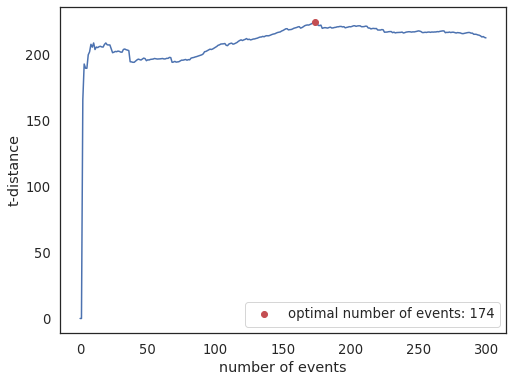

In [35]:
# Plot t-distance for varying number of events
sns.set(font_scale=1.2, style='white')
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(isfc_gsbs.tdists)
ax.set_xlabel(f'number of events')
ax.set_ylabel('t-distance')
ax.plot(isfc_gsbs.nstates,
        isfc_gsbs.tdists[isfc_gsbs.nstates],
        'ro', label=f'optimal number of events: {isfc_gsbs.nstates}')
plt.legend();

### Correlation matrix binned by GSBS event bounds for same test repeat and pair
For an example game and pair, visualize the GSBS events bounded and the ISFC matrix to determine whether there's any clear structure being picked up by the event bounds. 

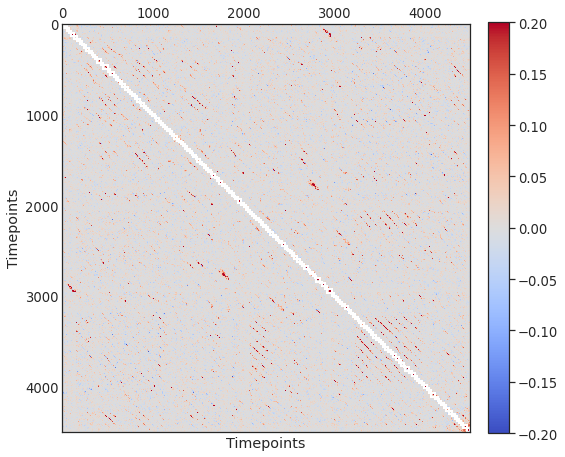

In [36]:
test_cf_vec = np.zeros((4501,5050))
n_timepoints = 4501
for t in np.arange(n_timepoints):
    test_cf_vec[t,] = vectorize_iscfs(iscfs[0,0,t,...])
# Plot event boxes over ISFC matrix
max_dur = 4501

sns.set(font_scale=1.2, style='white')
fig, ax = plt.subplots(figsize=(8, 8))
event_bounds = np.where(isfc_gsbs.bounds)[0]

bounds_aug = np.concatenate(([0], event_bounds, [n_timepoints]))
mat = ax.matshow(np.corrcoef(test_cf_vec)[:max_dur, :max_dur],
                 vmin=-.2, vmax=.2,cmap='coolwarm')
plt.colorbar(mat, fraction=0.046, pad=0.04)
for i in range(len(bounds_aug) - 1):
    rect = patches.Rectangle(
        (bounds_aug[i], bounds_aug[i]),
        bounds_aug[i+1] - bounds_aug[i],
        bounds_aug[i+1] - bounds_aug[i],
        linewidth = 2, edgecolor = 'w',facecolor = 'none'
    )
    ax.add_patch(rect)
plt.tick_params(axis='both', length=0)
plt.xlabel(f'Timepoints')
plt.ylabel(f'Timepoints');


Off-diagonal structure is not immediately apparent - Let's take a closer look into the first 1000 timepoints:


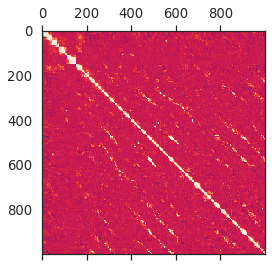

In [37]:
plt.matshow(np.corrcoef(test_cf_vec)[:1000,:1000],vmin=-.2,vmax=.2)

### Correlation matrix for GSBS game-state patterns binned by the 8 repeats
GSBS yields a set of template network events corresponding to centroid of each event. Next, we can compile these template network events across all repeats (games) and visualize the correlations between them.

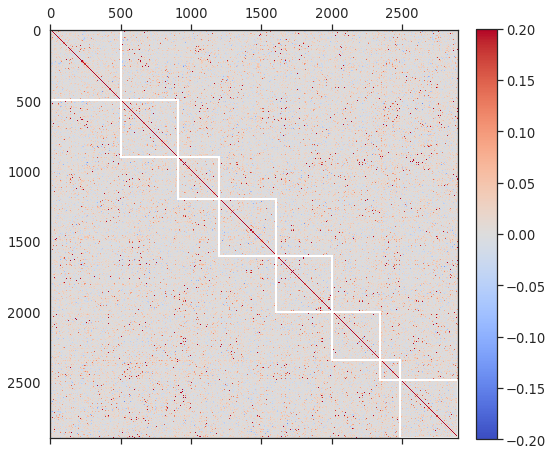

In [32]:
# Load in state patterns across multiple games
repeat_bounds = np.concatenate(([0], 
                    np.where(np.diff(repeat_ids[0]) > 0)[0] + 1,
                    [len(repeat_ids[0])]))

sns.set(font_scale=1.2, style='white')
fig, ax = plt.subplots(figsize=(8, 8))
mat = ax.matshow(np.corrcoef(np.vstack(gsbs_patterns[0])),
                 vmin=-.2, vmax=.2,cmap='coolwarm')
plt.colorbar(mat, fraction=0.046, pad=0.04)
for i in range(len(repeat_bounds) - 1):
    rect = patches.Rectangle(
        (repeat_bounds[i], repeat_bounds[i]),
        repeat_bounds[i+1] - repeat_bounds[i],
        repeat_bounds[i+1] - repeat_bounds[i],
        linewidth = 2, edgecolor = 'w',facecolor = 'none'
    )
    ax.add_patch(rect)

We wanted to verify that the game-state patterns were being split relatively equally amonst teams - results seem acceptable

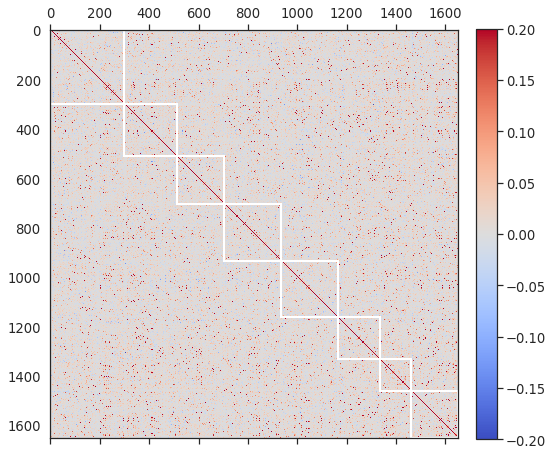

In [56]:
# Split repeated patterns by team color - shown here for team red
matchup = 0
team = 'red'

teams = ['red', 'blue', 'red', 'blue', 'blue', 'red', 'blue', 'red',
         'red', 'blue', 'red', 'blue', 'blue', 'red', 'blue', 'red']
team_ids = np.where(np.array(teams) == team)[0]

gsbs_team = np.vstack(np.array(gsbs_patterns[matchup],
                               dtype='object')[team_ids])

repeat_team = np.concatenate([[r] * len(g) for r, g in 
                    enumerate(np.array(gsbs_patterns[matchup],
                                       dtype='object')[team_ids])])
repeat_bounds = np.concatenate(([0], 
                    np.where(np.diff(repeat_team) > 0)[0] + 1,
                    [len(repeat_team)]))

sns.set(font_scale=1.2, style='white')
fig, ax = plt.subplots(figsize=(8, 8))
mat = ax.matshow(np.corrcoef(gsbs_team),
                 vmin=-.2, vmax=.2,cmap='coolwarm')
plt.colorbar(mat, fraction=0.046, pad=0.04)
for i in range(len(repeat_bounds) - 1):
    rect = patches.Rectangle(
        (repeat_bounds[i], repeat_bounds[i]),
        repeat_bounds[i+1] - repeat_bounds[i],
        repeat_bounds[i+1] - repeat_bounds[i],
        linewidth = 2, edgecolor = 'w',facecolor = 'none'
    )
    ax.add_patch(rect)

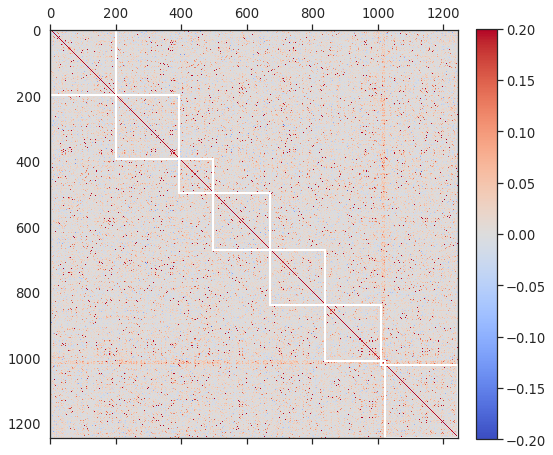

In [33]:
# blue team
matchup = 0
team = 'blue'

teams = ['red', 'blue', 'red', 'blue', 'blue', 'red', 'blue', 'red',
         'red', 'blue', 'red', 'blue', 'blue', 'red', 'blue', 'red']
team_ids = np.where(np.array(teams) == team)[0]

gsbs_team = np.vstack(np.array(gsbs_patterns[matchup],
                               dtype='object')[team_ids])

repeat_team = np.concatenate([[r] * len(g) for r, g in 
                    enumerate(np.array(gsbs_patterns[matchup],
                                       dtype='object')[team_ids])])
repeat_bounds = np.concatenate(([0], 
                    np.where(np.diff(repeat_team) > 0)[0] + 1,
                    [len(repeat_team)]))

sns.set(font_scale=1.2, style='white')
fig, ax = plt.subplots(figsize=(8, 8))
mat = ax.matshow(np.corrcoef(gsbs_team),
                 vmin=-.2, vmax=.2,cmap='coolwarm')
plt.colorbar(mat, fraction=0.046, pad=0.04)
for i in range(len(repeat_bounds) - 1):
    rect = patches.Rectangle(
        (repeat_bounds[i], repeat_bounds[i]),
        repeat_bounds[i+1] - repeat_bounds[i],
        repeat_bounds[i+1] - repeat_bounds[i],
        linewidth = 2, edgecolor = 'w',facecolor = 'none'
    )
    ax.add_patch(rect)

## GMM Clustering Analyses

Because the GSBS produced results with ~200 events in each game, we expect that similar events may be occurring repeatedly, discontiguously in time. Clustering can be used to group these template network events both within and across games. Here we use a Gaussian mixture model (GMM) to cluster similar template events. GMMs have two important hyperparameters: (1) the number of requested components (i.e. clusters), and (2) the richness of the covariance structure.

Covariance types:
* *spherical*: each cluster is spherical with matching variance along all dimensions and no covariance (least complex)
* *diagonal*: each cluster is eliptical with differing variance along different dimension but no covariance
* *full*: each cluster varies in both variance along different dimensions and covariance between dimensions (most complex)

We can assess the fit of a given model (i.e. clustering solution) penalized by it's complexity using the Bayesian information criterion (BIC). Lower BIC indicates a better model. First, we attempted to apply the GMM to the full (i.e. 5050-dimensional) template ISFC matrices; note that this entails clustering an ~3000 (template network event) by 5050 ISFC connections matrix.

### First Attempt: 30 components, no PCA

In [ ]:
# Use Gaussian mixture model to cluster ISFC events
from sklearn.mixture import GaussianMixture

matchup = 0
# team = 'blue'

# team_ids = np.where(np.array(teams) == team)[0]
# gsbs_team = np.vstack(np.array(gsbs_patterns[matchup],
                             #  dtype='object')[team_ids])
gsbs_team = np.vstack(np.array(gsbs_patterns[matchup],
                           dtype='object'))
# gsbs_arctanh = np.arctanh(gsbs_team)

k_grid = np.arange(1, 31)
cov_types = ['spherical', 'tied', 'diag', 'full']
gmm_bic = {'BIC': [], 'AIC': [], 'covariance': [], 'k': []}
for cov_type in cov_types:
    for k in k_grid:
        gmm = GaussianMixture(n_components=k,
                              covariance_type=cov_type)
        gmm.fit(gsbs_team)
        gmm_bic['BIC'].append(gmm.bic(gsbs_team))
        gmm_bic['AIC'].append(gmm.aic(gsbs_team))
        gmm_bic['covariance'].append(cov_type)
        gmm_bic['k'].append(k)
        print(f"Finished {cov_type} GMM with {k} components")

# np.save(f'results/gmm_arctanh_isfc_gsbs_k30_team-{team}_bic.npy',
        # gmm_bic)
np.save(f'results/gmm_arctanh_isfc_gsbs_k30_bic.npy',
    gmm_bic)


/jukebox/hasson/ag42/miniconda3/envs/ctf/lib/python3.7/site-packages/seaborn/categorical.py:3772: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


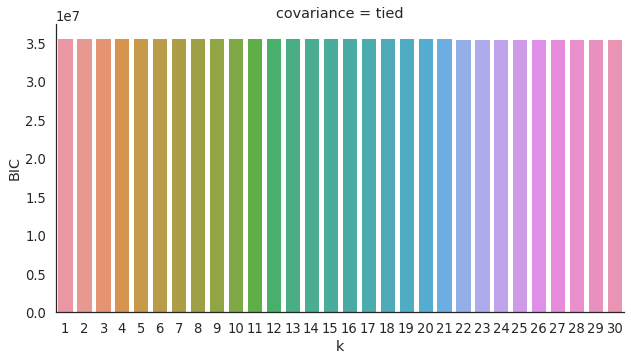

In [85]:
sns.catplot(x='k', y='BIC', col='covariance', kind='bar',
            data=gmm_bic[gmm_bic['covariance'].isin(
                ['tied'])],ax=ax, aspect=1.75)

These results are very inconclusive. There's no K for which we see a meaningful capture of the data - maybe it's because the dimensionality is too high. The same is true for other covariance types either (shown below)

/jukebox/hasson/ag42/miniconda3/envs/ctf/lib/python3.7/site-packages/seaborn/categorical.py:3772: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)
/jukebox/hasson/ag42/miniconda3/envs/ctf/lib/python3.7/site-packages/seaborn/categorical.py:3772: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


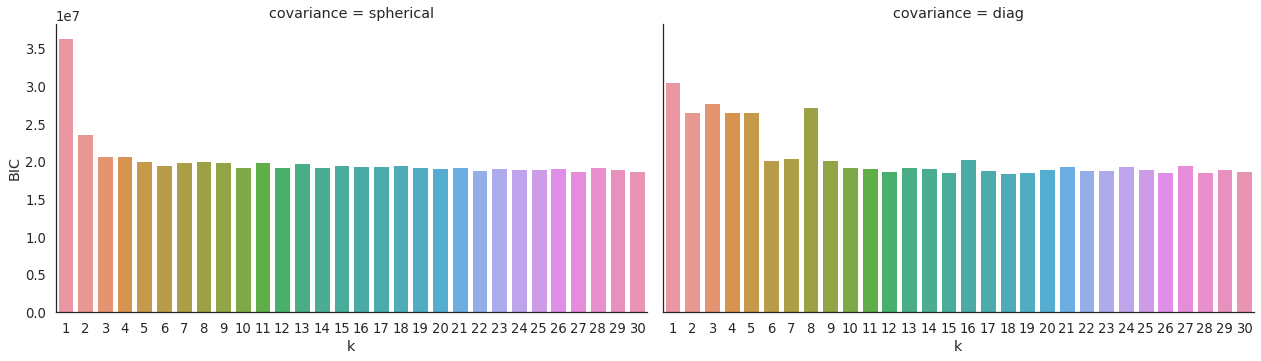

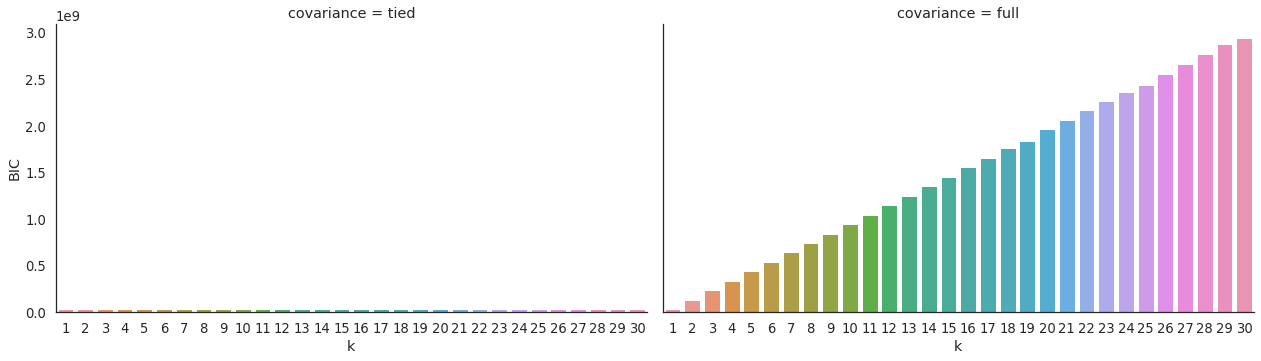

In [75]:
import pandas as pd
gmm_bic = np.load('results/gmm_arctanh_isfc_gsbs_k30_bic.npy',
                   allow_pickle=True).item()
gmm_bic = pd.DataFrame(gmm_bic)

sns.catplot(x='k', y='BIC', col='covariance', kind='bar',
            data=gmm_bic[gmm_bic['covariance'].isin(
                ['spherical', 'diag'])], ax=ax, aspect=1.75)
sns.catplot(x='k', y='BIC', col='covariance', kind='bar',
            data=gmm_bic[gmm_bic['covariance'].isin(
                ['full', 'tied'])], ax=ax, aspect=1.75)

### Attempt Two: PCA GSBS results first w/ 684 components (90% VAF), then 30 component GMM

The results from the first analysis weren't very conclusive so we wanted to see what would happen if we first PCA'ed the GSBS results and then ran the GMM

The PCA converts the (~ 3000 total state patterns by 5050 ISFC connections) matrix into (~3000 x 684 orthogonal dimensions)


In [97]:
# PCA to reduce dimensionality of ISFC events
from sklearn.decomposition import PCA

n_matchups = [0]
# team = 'blue'    
percents = [.5, .75, .9, .95, .99, 1.0]
gsbs_reduced = []
gsbs_vaf = []
for matchup in n_matchups:
1
    # team_ids = np.where(np.array(teams) == team)[0]
    gsbs_team = np.vstack(np.array(gsbs_patterns[matchup],
                               dtype='object'))
    # gsbs_arctanh = np.arctanh(gsbs_team)

    
    k = 2898 # max dimension

    pca = PCA(n_components=k)
    gsbs_reduced.append(pca.fit_transform(gsbs_team))
    print(f"\nApplied PCA to ISFC events for matchup {matchup}")
    vaf_dims = {}
    for percent in percents:
        n_dims = np.sum(np.cumsum(pca.explained_variance_ratio_)
                        <= percent)
        vaf_dims[percent] = n_dims
        print(f"{percent:.0%} variance accoounted for: "
              f"{n_dims} components")
    gsbs_vaf.append(vaf_dims)



Applied PCA to ISFC events for matchup 0
50% variance accoounted for: 3 components
75% variance accoounted for: 184 components
90% variance accoounted for: 683 components
95% variance accoounted for: 1081 components
99% variance accoounted for: 1869 components
100% variance accoounted for: 2898 components


In [ ]:
# Run GMM on PCA-reduced ISFC events
matchup = 0

k_grid = np.arange(1, 31)
cov_types = ['spherical', 'tied', 'diag', 'full']
gmm_bic = {'BIC': [], 'AIC': [], 'covariance': [],
           'k': [], 'PCA VAF': []}
percents = [.5, .75, .9, .95, .99, 1.0]
for percent in percents:
    for cov_type in cov_types:
        for k in k_grid:
            gsbs_trunc = gsbs_reduced[matchup][
                :, :gsbs_vaf[matchup][percent]]
            gmm = GaussianMixture(n_components=k,
                                  covariance_type=cov_type)
            gmm.fit(gsbs_trunc)
            gmm_bic['BIC'].append(gmm.bic(gsbs_trunc))
            gmm_bic['AIC'].append(gmm.aic(gsbs_trunc))
            gmm_bic['covariance'].append(cov_type)
            gmm_bic['k'].append(k)
            gmm_bic['PCA VAF'].append(percent)
            print(f"Finished {cov_type} GMM at {percent:.0%} VAF "
                  f"({gsbs_vaf[matchup][percent]} dimensions "
                  f"with {k} components")

np.save(f'results/gmm_pca-arctanh_isfc_gsbs_k30_bic.npy',
        gmm_bic)

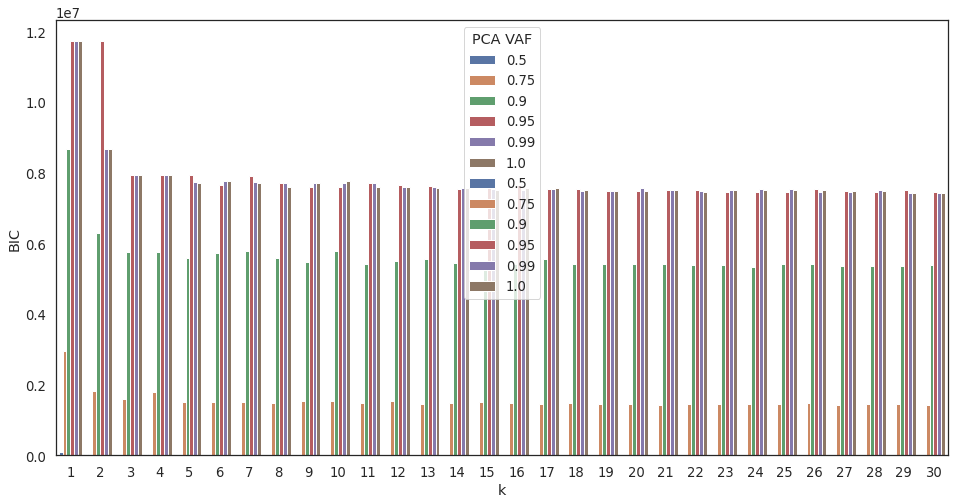

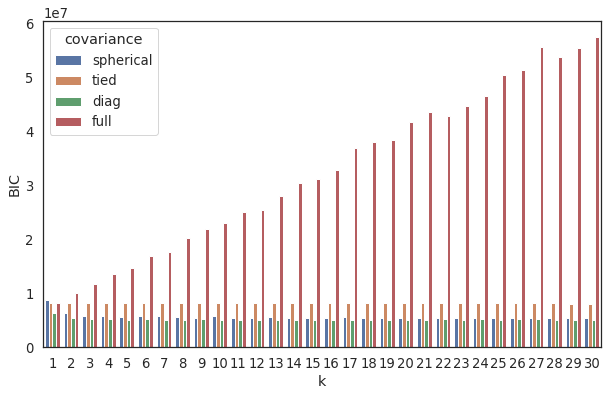

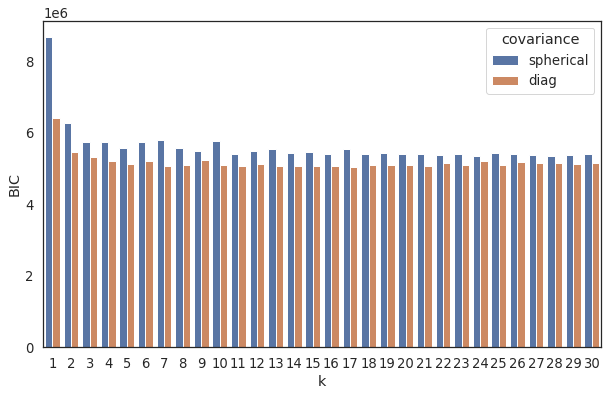

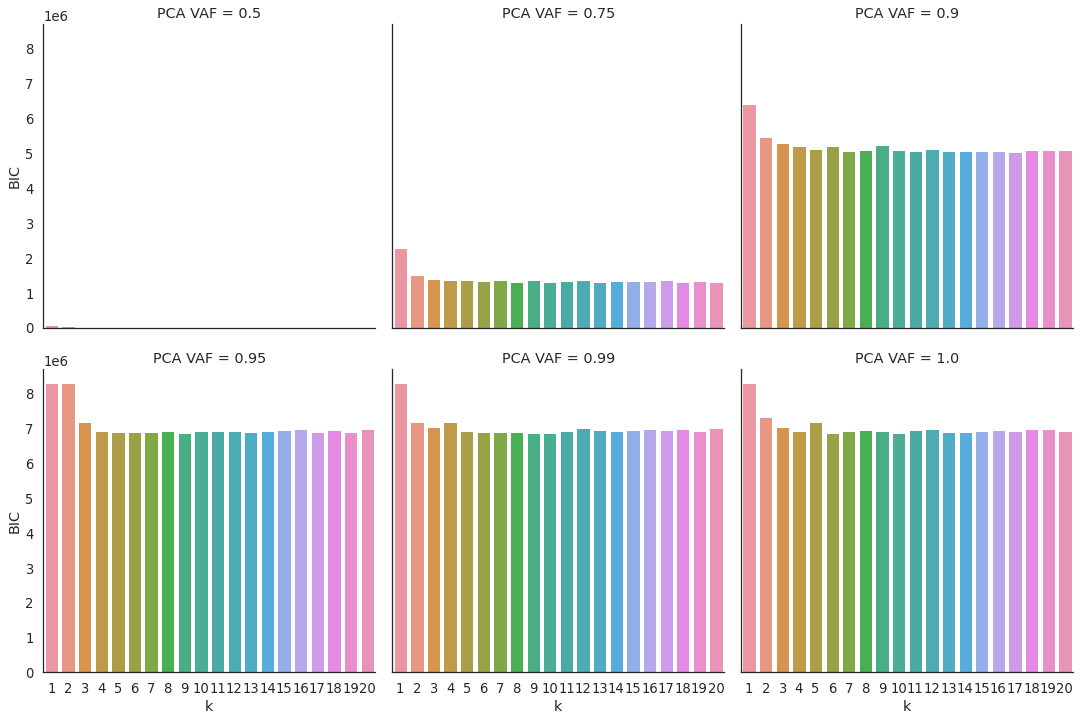

In [124]:
# Visualizations of BIC at different numbers of clusters and at different PCA VAF levels
# first plot shows BIC for diagonal GMM at different PCA VAF and k
# second - BIC of different GMM models for different k at PCA VAF = .90
# third - comparison of spherical and diagonal at VAF = .90
# fourth - Diagonal GMM at different VAF
gmm_bic = np.load('results/gmm_pca-arctanh_isfc_gsbs_k30_bic.npy',
                   allow_pickle=True).item()
gmm_bic = pd.DataFrame(gmm_bic)
gmm_trunc = gmm_bic[(gmm_bic['covariance'] == 'diag')]
#gmm_trunc = gmm_bic[(gmm_bic['covariance'] == 'spherical') &
                    #(gmm_bic['PCA VAF'] == .75)]
fig, ax = plt.subplots(figsize=(16,8))

sns.barplot(x='k', y='BIC', ax=ax, data=gmm_trunc,hue = gmm_bic['PCA VAF'])

gmm_trunc = gmm_bic[(gmm_bic['covariance'] == 'spherical')]
sns.barplot(x='k', y='BIC', hue='PCA VAF',
            data=gmm_trunc)

fig, ax = plt.subplots(figsize=(10, 6))
gmm_trunc = gmm_bic[(gmm_bic['PCA VAF'] == .90)]
sns.barplot(x='k', y='BIC', hue='covariance',
            data=gmm_trunc, ax=ax)

cov_types = ['spherical', 'diag']
fig, ax = plt.subplots(figsize=(10, 6))
gmm_trunc = gmm_bic[(gmm_bic['PCA VAF'] == .90) &
                    (gmm_bic['covariance'].isin(cov_types))]
sns.barplot(x='k', y='BIC', hue='covariance',
            data=gmm_trunc, ax=ax)

gmm_trunc = gmm_bic[(gmm_bic['covariance'] == 'diag') &
                    (gmm_bic['k'] <= 20)]
sns.catplot(x='k', y='BIC', col='PCA VAF', col_wrap=3,
            data=gmm_trunc, kind='bar')

Results show decrease in BIC for first 5 clusters (evident in VAF = .90) and then slight increase back up with k = 6

In [104]:
n_repeats = 8
n_pairs = 6

states_vec = np.zeros((n_repeats,n_pairs))
for r in np.arange(n_repeats):
    for pair in np.arange(n_pairs):
        test_load = np.load(f'results/gsbs_z_iscfs-matchup-0_'
        f'repeat-{r}_pair-{pair}_results.npy', allow_pickle=True).item()
        states_vec[r,pair] = test_load.states[-1]
        print(f"loaded repeat {r}, pair {pair})

In [9]:
n_timepoints = 4501
test_cf_vec = np.zeros((4501,5050))
for t in np.arange(n_timepoints):
            test_cf_vec[t,] = vectorize_iscfs(iscfs[0,5,t,...])
from scipy.stats import zscore
cf_vecs = zscore(test_cf_vec,axis=0)

### Based on Results from previous PCA + GMM combo, Run GMM at k = 5 Components

Looking at PCA VAF = .90 and the diagonal covariance in the bottom graph, BIC seems to monotonically decrease until k = 6 components, where there's a slight uptick, so GMM was run at 5 components for further visualization

In [ ]:
# Run at 90% VAF with score
from sklearn.decomposition import PCA

n_matchups = [0]   
percents = [.5, .75, .9, .95, .99, 1.0]
gsbs_reduced_90 = []
gsbs_vaf_90 = []
for matchup in n_matchups:
    # team_ids = np.where(np.array(teams) == team)[0]
    gsbs_team = np.vstack(np.array(gsbs_patterns[matchup],dtype='object'))
    # gsbs_arctanh = np.arctanh(gsbs_team)

    k = 684 # or 683 (90% VAF)

    pca_90 = PCA(n_components=k)
    gsbs_reduced_90.append(pca_90.fit_transform(zscore(gsbs_team,axis=0)))
    # 90% VAF (684 components) & k = 5 GMM components
    # PCA to reduce dimensionality of ISFC events
    k = 5
    gsbs_trunc = gsbs_reduced_90[matchup]
    #gmm_90 = GaussianMixture(n_components=k,
     #                     covariance_type='diag')
   # gmm_90.fit(gsbs_trunc)

    
    print(f"\nApplied PCA to ISFC events for matchup {matchup}")
    vaf_dims = {}
    for percent in percents:
        n_dims = np.sum(np.cumsum(pca_90.explained_variance_ratio_)
                        <= percent)
        vaf_dims[percent] = n_dims
        print(f"{percent:.0%} variance accoounted for: "
              f"{n_dims} components")
    gsbs_vaf_90.append(vaf_dims)
    

#np.save(f'results/gmm_pca-arctanh_isfc_gsbs_k5_bic.npy',gmm_90)

In [ ]:
matchup = 0

k_grid = np.arange(1, 6)
cov_types = ['spherical', 'tied', 'diag', 'full']
gmm_bic = {'BIC': [], 'AIC': [], 'covariance': [],
           'k': [], 'PCA VAF': []}
percents = [.5, .75, .9, .95, .99, 1.0]
for percent in percents:
    for cov_type in cov_types:
        for k in k_grid:
            gsbs_trunc = gsbs_reduced_90[matchup][
                :, :gsbs_vaf_90[matchup][percent]]
            gmm = GaussianMixture(n_components=k,
                                  covariance_type=cov_type)
            gmm.fit(gsbs_trunc)
            gmm_bic['BIC'].append(gmm.bic(gsbs_trunc))
            gmm_bic['AIC'].append(gmm.aic(gsbs_trunc))
            gmm_bic['covariance'].append(cov_type)
            gmm_bic['k'].append(k)
            gmm_bic['PCA VAF'].append(percent)
            print(f"Finished {cov_type} GMM at {percent:.0%} VAF "
                  f"({gsbs_vaf_90[matchup][percent]} dimensions "
                  f"with {k} components")

np.save(f'results/gmm_pca-arctanh_isfc_gsbs_k5_bic.npy',
        gmm_bic)

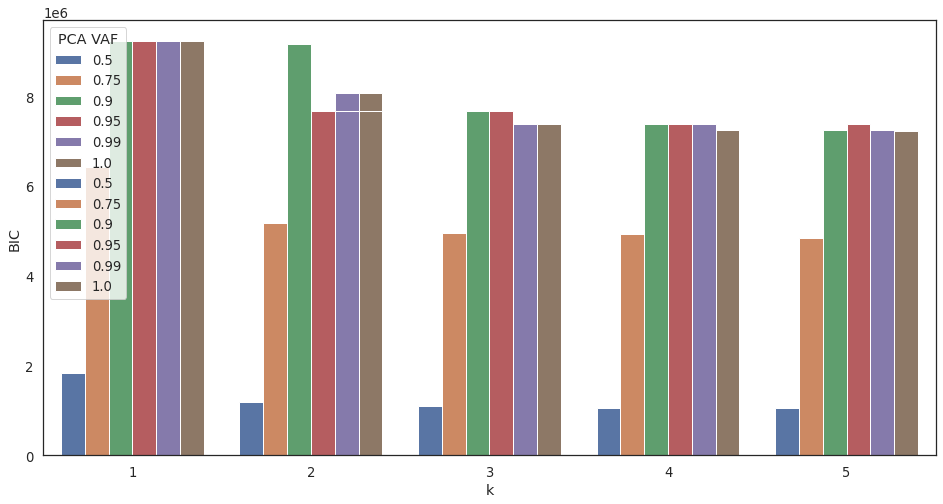

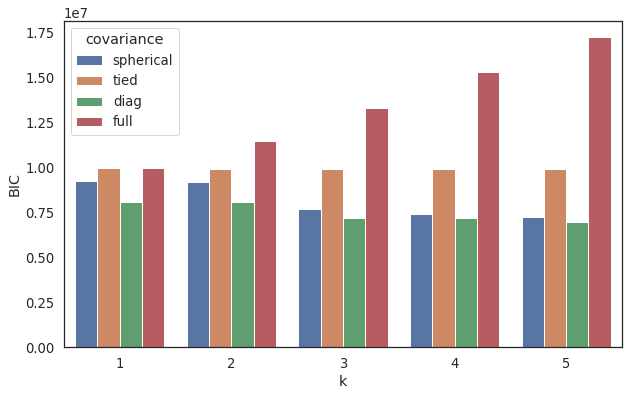

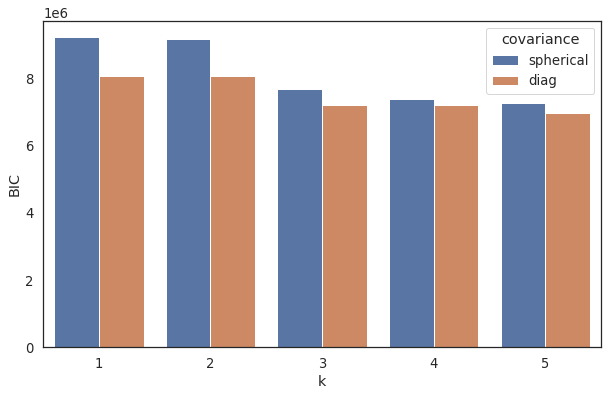

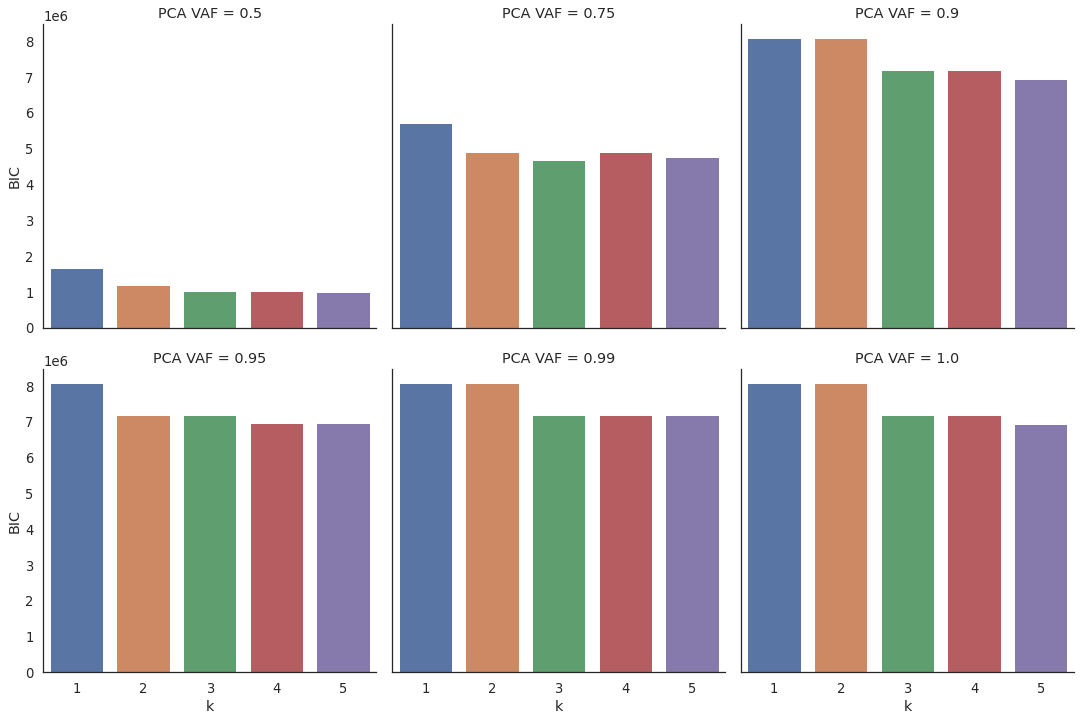

In [108]:
gmm_bic = np.load('results/gmm_pca-arctanh_isfc_gsbs_k5_bic.npy',
                   allow_pickle=True).item()
gmm_bic = pd.DataFrame(gmm_bic)
gmm_trunc = gmm_bic[(gmm_bic['covariance'] == 'diag')]
#gmm_trunc = gmm_bic[(gmm_bic['covariance'] == 'spherical') &
                    #(gmm_bic['PCA VAF'] == .75)]
fig, ax = plt.subplots(figsize=(16,8))

sns.barplot(x='k', y='BIC', ax=ax, data=gmm_trunc,hue = gmm_bic['PCA VAF'])

gmm_trunc = gmm_bic[(gmm_bic['covariance'] == 'spherical')]
sns.barplot(x='k', y='BIC', hue='PCA VAF',
            data=gmm_trunc)

fig, ax = plt.subplots(figsize=(10, 6))
gmm_trunc = gmm_bic[(gmm_bic['PCA VAF'] == .90)]
sns.barplot(x='k', y='BIC', hue='covariance',
            data=gmm_trunc, ax=ax)

cov_types = ['spherical', 'diag']
fig, ax = plt.subplots(figsize=(10, 6))
gmm_trunc = gmm_bic[(gmm_bic['PCA VAF'] == .90) &
                    (gmm_bic['covariance'].isin(cov_types))]
sns.barplot(x='k', y='BIC', hue='covariance',
            data=gmm_trunc, ax=ax)

gmm_trunc = gmm_bic[(gmm_bic['covariance'] == 'diag') &
                    (gmm_bic['k'] <= 20)]
sns.catplot(x='k', y='BIC', col='PCA VAF', col_wrap=3,
            data=gmm_trunc, kind='bar')

## Miscellaneous Visualizations of GSBS Results and ISFC Results

### GMM Cluster Means (k = 5) projected into the 100 by 100 Cofluctuation space 

The GMM with k = 5 learns 5 clusters with means corresponding to PCA-reduced ISFC matrices. Using `pca.inverse_transform()` (from the PCA used to reduce the 5050-dimensional ISFC matrices for GMM), we can project the GMM cluster means back into the original 5050 dimensions and visualize them as 100 by 100 ISFC matrices. Note that the PCs are ordered by variance so the top-left corner of the ISFC matrices corresponds to the highest-variance PCs.

In [83]:
reverse_pca = pca_90.inverse_transform(gmm_90.means_)

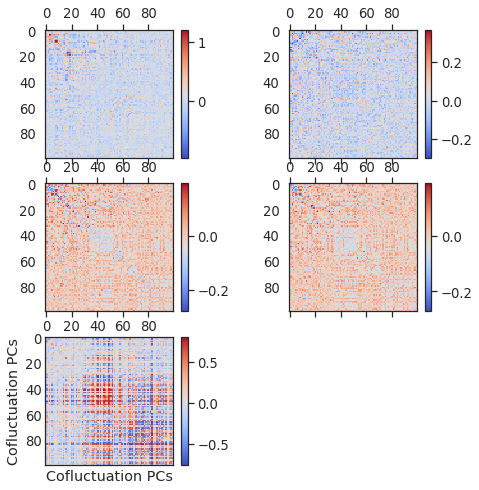

In [84]:
# Visualize GMM cluster ISFC matrices
sns.set(font_scale=1.2, style='white')
fig, axs = plt.subplots(3,2,figsize=(8, 8))
fig.delaxes(axs[2,1])
square_reverse_pca = [square_iscfs(r) for r in reverse_pca]
for s,ax in zip(square_reverse_pca,axs.ravel()):        
    mat = ax.matshow(s, cmap='coolwarm')
    plt.colorbar(mat, ax=ax, fraction=0.046, pad=0.04)
    plt.tick_params(axis='both', length=0)
    plt.xlabel(f'Cofluctuation PCs')
    plt.ylabel(f'Cofluctuation PCs')

### 

**Example for a given pair and repeat ISFC Matrix from the original Cofluctuation data**

ISFC matrix at 9 different timepoints for a within-team pair. This is an example of a basis for comparison for the 5 GMM Cluster Means projected back into ISFC space shown above

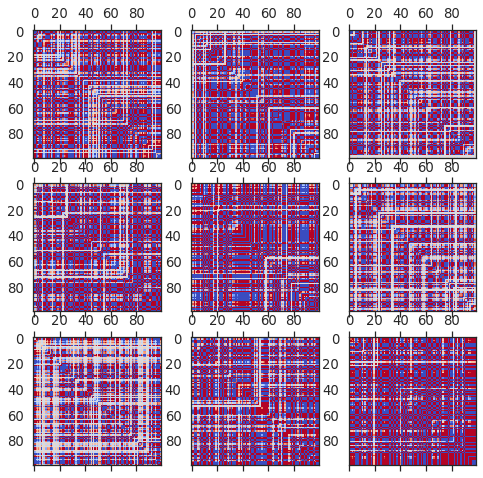

In [105]:
sns.set(font_scale=1.2, style='white')
fig, axs = plt.subplots(3,3,figsize=(8, 8))

count = 0
for r in np.arange(3):
    for c in np.arange(3):
        count += 1
        cf = iscfs[0,0,count*500,...]
        axs[r,c].matshow(cf, vmin=-.2, vmax=.2,cmap='coolwarm')

### GMM clustering labels for the 2898 GSBS state patterns  

In [66]:
k = 5
gmm = GaussianMixture(n_components=k, covariance_type='diag')
labels_fp = gmm.fit_predict(gsbs_reduced_90[0][:,:684])

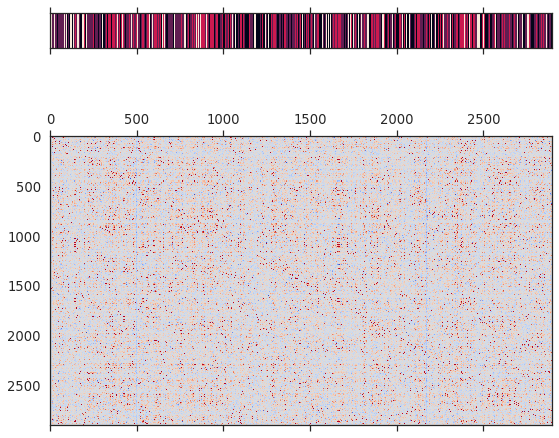

In [69]:
sns.set(font_scale=1.2, style='white')
fig, axs = plt.subplots(2,1,figsize=(8, 8),sharex=True)
axs[0].matshow(np.repeat(labels_fp[:,np.newaxis],200,axis=1).T)
axs[0].get_yaxis().set_ticks([])

mat = axs[1].matshow(np.corrcoef(np.vstack(gsbs_reduced_90[0][:,:684])),
                 vmin=-.2, vmax=.2,cmap='coolwarm')
axs[1].set_aspect('auto')
plt.tight_layout()
# plt.colorbar(mat, fraction=0.046, pad=0.04)

### PCA 684 components (90% VAF) and GMM k = 5 Components

In [53]:
# run at 90% VAF with score
from sklearn.decomposition import PCA
from scipy.stats import zscore

n_matchups = [0]   
percents = [.5, .75, .9, .95, .99, 1.0]
gsbs_reduced_90 = []
for matchup in n_matchups:
    # team_ids = np.where(np.array(teams) == team)[0]
    gsbs_team = np.vstack(np.array(gsbs_patterns[matchup],dtype='object'))
    # gsbs_arctanh = np.arctanh(gsbs_team)

    k = 684

    pca_90 = PCA(n_components=k)
    gsbs_reduced_90.append(pca_90.fit_transform(zscore(gsbs_team,axis=0)))
    # 90% VAF (684 components) & k = 5 GMM components
    # PCA to reduce dimensionality of ISFC events
    k = 5
    gsbs_trunc = gsbs_reduced_90[matchup]
    gmm_90 = GaussianMixture(n_components=k,
                          covariance_type='diag')
    gmm_90.fit(gsbs_trunc)

# np.save(f'results/gmm_pca-arctanh_isfc_gsbs_k6_bic.npy',gmm_bic)

### Visualize GMM label results projected back into 4500 timepoint space

To cluster the original dynamic ISFC time series, we can project the ISFCs (5050-dimensional cofluctuation time series) and project them down to 684 dimensions using the PCA trained on the GSBS template network events. We can then use the `.predict()` GMM method to assign the PCA-reduced ISFC matrix at each time point to the nearest GMM cluster. We can visualize these cluster assignments for individual cooperative pairs and repeats.

*visualized only for the first pair and repeat - you would have 16 of these total (8 repeats * 2 pairs each)*


In [90]:
count = 0
pair_id = [0,5]
n_timepoints = 4501
predict = np.zeros((n_timepoints,n_repeats*2))
for r in np.arange(n_repeats):
    for pair in pair_id:
        iscfs_object = np.zeros((4501,5050))
        for t in np.arange(n_timepoints):
            iscfs_object[t,] = vectorize_iscfs(iscfs[r,pair,t,...])
        
        iscfs_pca = pca_90.transform(iscfs_object)
        predict[:,count] = gmm_90.predict(iscfs_pca[:,:684])
        count = count + 1
        

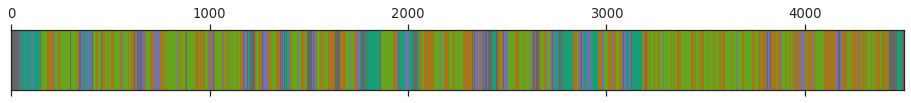

In [92]:
plt.matshow(np.repeat(predict[:,0][:,np.newaxis],300,axis=1).T,cmap='Dark2')
fig = plt.gca()
fig.axes.get_yaxis().set_visible(False)

In [93]:
predict_expand = np.full((5,4501),np.nan)
for i,p in enumerate(predict[:,0]):
    predict_expand[int(p),i] = p

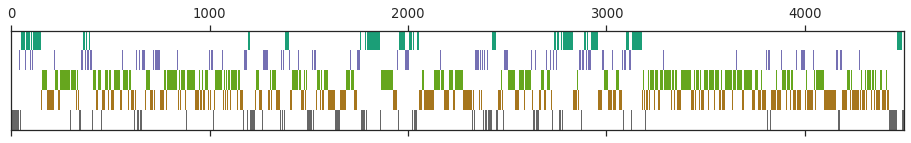

In [94]:
# Labels for example repeat and pair for whole 4500 timepoints visualized
plt.matshow(np.repeat(predict_expand,100,axis=0),cmap='Dark2')
fig = plt.gca()
fig.axes.get_yaxis().set_visible(False)

### Correlate labels with a few in-game behaviors
Finally, we can begin to explore whether the time series of network event labels corresponds to any behaviors.

Here, we look at the timeseries for being near one's teammate, camping your own base, camping your opponent's base, and approaching one's teammate

In [107]:
from os.path import join
from scipy.stats import pearsonr, zscore
from statistical_tests import (fisher_mean, block_iscf, 
                               block_randomization)
from ctf_dataset.load import create_wrapped_dataset

# Import behavior heuristics
from ctf_dataset.behaviours.heuristic import (
                                              near_teammate,
                                              camp_own_base,
                                              camp_opponent_base,
                                              approaching_teammate)
                                          
# Set base directory 
base_dir = '/jukebox/hasson/snastase/social-ctf'
data_dir = join(base_dir, 'data')

# Create wrapped CTF dataset
wrap_f = create_wrapped_dataset(data_dir, output_dataset_name="virtual.hdf5")

map_id = 0 # 0
matchup_id = 0 # 0-54 (0, 34, 49, 54)
repeat_id = slice(None) # 0-7
player_id = slice(None) # 0-3



# Compute near teammate behavior time series (symmetric)
nears = near_teammate(wrap_f, map_id=map_id, matchup_id=matchup_id,
                      repeat_id=slice(None), player_id=slice(None),
                      min_behaviour_length=15, teammate_radius=3).squeeze()


# Compute base-camping behavior time series (symmetric)
approachs = approaching_teammate(wrap_f, map_id=map_id,
                                 matchup_id=matchup_id,
                                 repeat_id=slice(None),
                                 player_id=slice(None),
                                 min_behaviour_length=15,
                                 min_approach=.5).squeeze()

# Compute base-camping behavior time series (asymmetric)
basecamps = camp_own_base(wrap_f, map_id=map_id, matchup_id=matchup_id,
                          repeat_id=slice(None), player_id=slice(None),
                          min_behaviour_length=15,
                          base_radius=3).squeeze()

# Compute base-camping behavior time series (asymmetric)
spawncamps = camp_opponent_base(wrap_f, map_id=map_id,
                                matchup_id=matchup_id,
                                repeat_id=slice(None),
                                player_id=slice(None),
                                min_behaviour_length=15,
                                base_radius=3).squeeze()

In [128]:
# Near Teammate behavior timeseries correlated with the cluster labels. Output is 16 (2 within-team pairs * 8 repeats) by 4 (total agents)
# Because being near one's teammate is a behavior shared by both teammates, there's symmetry in the output (column 0 = 1; column 2 = 3)
n_agents = nears.shape[1]
n_timeseries = predict.shape[1]
n_labels = 5
corr_coef = np.zeros((n_timeseries,n_agents,n_labels))

for num in np.arange(n_timeseries):
    predict_expand = np.zeros((n_labels,4501))
    for i,p in enumerate(predict[:,num]):
        predict_expand[int(p),i] = 1
    for agent in np.arange(n_agents):
        for label in np.arange(n_labels):
            corr_coef[num,agent,label] = pearsonr(predict_expand[label,:],nears[int(np.floor(num/2)),agent,:])[0]      

print(f"Mean Correlation with Near Teammate for each player \n" 
      f"(columns = players, rows = event clusters) \n {np.mean(corr_coef,axis=0).T}")


Mean Correlation with Near Teammate for each player 
(columns = players, rows = event clusters) 
 [[ 0.02266826  0.02266826  0.07487207  0.07487207]
 [-0.03612173 -0.03612173 -0.03256857 -0.03256857]
 [-0.01130475 -0.01130475 -0.04527095 -0.04527095]
 [-0.00796675 -0.00796675 -0.01288829 -0.01288829]
 [ 0.04634424  0.04634424  0.0588348   0.0588348 ]]


In [129]:
# Approaching Teammate behavior
n_agents = nears.shape[1]
n_timeseries = predict.shape[1]
n_labels = 5
corr_coef = np.zeros((n_timeseries,n_agents,n_labels))

for num in np.arange(n_timeseries):
    predict_expand = np.zeros((n_labels,4501))
    for i,p in enumerate(predict[:,num]):
        predict_expand[int(p),i] = 1
    for agent in np.arange(n_agents):
        for label in np.arange(n_labels):
            corr_coef[num,agent,label] = pearsonr(predict_expand[label,:],approachs[int(np.floor(num/2)),agent,:])[0]      

print(f"Mean Correlation with Approaching Teammate for each player \n" 
      f"(columns = players, rows = event clusters) \n {np.mean(corr_coef,axis=0).T}")


Mean Correlation with Approaching Teammate for each player 
(columns = players, rows = event clusters) 
 [[ 0.03391325  0.03391325  0.00280933  0.00280933]
 [ 0.02951495  0.02951495  0.02086054  0.02086054]
 [-0.07156718 -0.07156718 -0.05232081 -0.05232081]
 [ 0.04280867  0.04280867  0.06137384  0.06137384]
 [-0.00351207 -0.00351207 -0.02775347 -0.02775347]]


In [130]:
# camping one's own base
n_agents = nears.shape[1]
n_timeseries = predict.shape[1]
n_labels = 5
corr_coef = np.zeros((n_timeseries,n_agents,n_labels))

for num in np.arange(n_timeseries):
    predict_expand = np.zeros((n_labels,4501))
    for i,p in enumerate(predict[:,num]):
        predict_expand[int(p),i] = 1
    for agent in np.arange(n_agents):
        for label in np.arange(n_labels):
            corr_coef[num,agent,label] = pearsonr(predict_expand[label,:],basecamps[int(np.floor(num/2)),agent,:])[0]      

print(f"Mean Correlation with Camping one's own Base for each player \n" 
      f"(columns = players, rows = event clusters) \n {np.mean(corr_coef,axis=0).T}")



Mean Correlation with Camping one's own Base for each player 
(columns = players, rows = event clusters) 
 [[ 0.02886238  0.04197014  0.00067367  0.00376994]
 [ 0.01709849  0.01118009  0.02562463  0.00684282]
 [-0.03445532 -0.04832258 -0.06653903 -0.03897244]
 [-0.01388579 -0.01492511  0.00449895  0.01029395]
 [ 0.02689612  0.04280682  0.0675461   0.03005339]]


In [131]:
# camping other team's base
n_agents = nears.shape[1]
n_timeseries = predict.shape[1]
n_labels = 5
corr_coef = np.zeros((n_timeseries,n_agents,n_labels))

for num in np.arange(n_timeseries):
    predict_expand = np.zeros((n_labels,4501))
    for i,p in enumerate(predict[:,num]):
        predict_expand[int(p),i] = 1
    for agent in np.arange(n_agents):
        for label in np.arange(n_labels):
            corr_coef[num,agent,label] = pearsonr(predict_expand[label,:],spawncamps[int(np.floor(num/2)),agent,:])[0]      

print(f"Mean Correlation with Camping other Team's Base for each player \n" 
      f"(columns = players, rows = event clusters) \n {np.mean(corr_coef,axis=0).T}")



Mean Correlation with Camping other Team's Base for each player 
(columns = players, rows = event clusters) 
 [[ 0.02615938  0.01765793  0.06726117  0.08299638]
 [ 0.17926992  0.14359119  0.1550639   0.15683436]
 [-0.17008006 -0.17693609 -0.16711503 -0.18221654]
 [-0.02635679  0.02346936 -0.04318116 -0.01597748]
 [ 0.08897679  0.07542917  0.09149535  0.06951491]]


note: We see correlation of roughly .15 (both positive and negative) for clusters 2 and 3 with spawn camping behavior